In [1]:
# https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/updating_priors.ipynb


# This shows how to have some data and update priors form posterious as we get more data


## NOTE this requires Pymc3 3.1

# Updating priors
In this notebook, I will show how it is possible to update the priors as new data becomes available. The example is a slightly modified version of the linear regression in the Getting started with PyMC3 notebook.

In [17]:
# pymc3.distributions.DensityDist?

In [2]:

import matplotlib.pyplot as plt
import matplotlib as mpl
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats

%matplotlib inline

%load_ext version_information

%version_information pymc3

Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
pymc3 3.1
Tue Aug 08 14:34:03 2017 MDT

## Generating data

In [3]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha_true = 5
beta0_true = 7
beta1_true = 13

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

## Model specification
Our initial beliefs about the parameters are quite informative (sd=1) and a bit off the true values.

In [4]:
basic_model = Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=1)
    beta0 = Normal('beta0', mu=12, sd=1)
    beta1 = Normal('beta1', mu=18, sd=1)
    
    # Expected value of outcome
    mu = alpha + beta0 * X1 + beta1 * X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=1, observed=Y)
    
    # draw 1000 posterior samples
    trace = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 180.72:   9%|▉         | 18724/200000 [00:01<00:18, 9914.78it/s]
Convergence archived at 19400
Interrupted at 19,400 [9%]: Average Loss = 958.67
100%|██████████| 1500/1500 [00:01<00:00, 1367.02it/s]


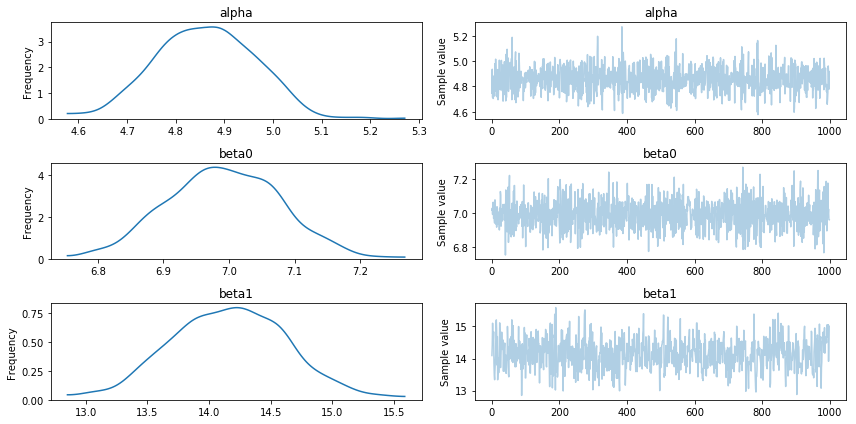

In [5]:
traceplot(trace);



In order to update our beliefs about the parameters, we use the posterior distributions, which will be used as the prior distributions for the next inference. The data used for each inference iteration has to be independent from the previous iterations, otherwise the same (possibly wrong) belief is injected over and over in the system, amplifying the errors and misleading the inference. By ensuring the data is independent, the system should converge to the true parameter values.

Because we draw samples from the posterior distribution (shown on the right in the figure above), we need to estimate their probability density (shown on the left in the figure above). Kernel density estimation (KDE) is a way to achieve this, and we will use this technique here. In any case, it is an empirical distribution that cannot be expressed analytically. Fortunately PyMC3 provides a way to use custom distributions, via Interpolated class.

In [6]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

Now we just need to generate more data and build our Bayesian model so that the prior distributions for the current iteration are the posterior distributions from the previous iteration. It is still possible to continue using NUTS sampling method because Interpolated class implements calculation of gradients that are necessary for Hamiltonian Monte Carlo samplers.


In [7]:
traces = [trace]


In [8]:
for _ in range(10):

    # generate more data
    X1 = np.random.randn(size)
    X2 = np.random.randn(size) * 0.2
    Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

    model = Model()
    with model:
        # Priors are posteriors from previous iteration
        alpha = from_posterior('alpha', trace['alpha'])
        beta0 = from_posterior('beta0', trace['beta0'])
        beta1 = from_posterior('beta1', trace['beta1'])

        # Expected value of outcome
        mu = alpha + beta0 * X1 + beta1 * X2

        # Likelihood (sampling distribution) of observations
        Y_obs = Normal('Y_obs', mu=mu, sd=1, observed=Y)
                
        # draw 10000 posterior samples
        trace = sample(1000)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 130.05:   6%|▌         | 12258/200000 [00:03<00:49, 3758.99it/s]
Convergence archived at 12300
Interrupted at 12,300 [6%]: Average Loss = 145.76
100%|██████████| 1500/1500 [00:04<00:00, 366.29it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 136.93:   6%|▌         | 12221/200000 [00:03<00:48, 3833.78it/s]
Convergence archived at 12300
Interrupted at 12,300 [6%]: Average Loss = 147.82
100%|██████████| 1500/1500 [00:03<00:00, 415.15it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 139.19:   5%|▌         | 10760/200000 [00:02<00:45, 4169.32it/s]
Convergence archived at 11100
Interrupted at 11,100 [5%]: Average Loss = 149.28
100%|██████████| 1500/1500 [00:03<00:00, 408.66it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 141.75:   5%|▌         | 10457/200000 [00:02<00:51, 3691.59it/s]
Convergence archived at 10500

Posterior distributions after 11 iterations.


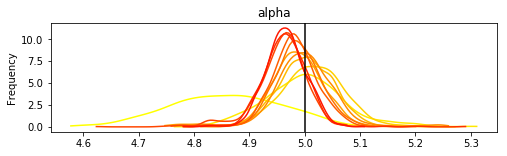

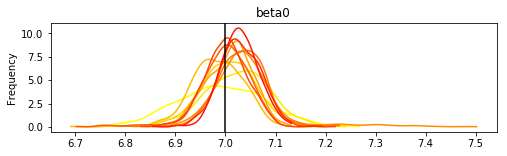

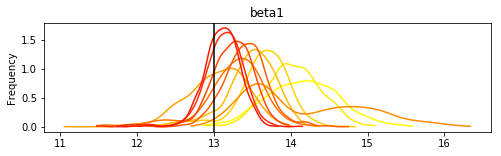

In [9]:
print('Posterior distributions after ' + str(len(traces)) + ' iterations.')
cmap = mpl.cm.autumn
for param in ['alpha', 'beta0', 'beta1']:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({'alpha': alpha_true, 'beta0': beta0_true, 'beta1': beta1_true}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)
    plt.show()

You can re-execute the last two cells to generate more updates.

What is interesting to note is that the posterior distributions for our parameters tend to get centered on their true value (vertical lines), and the distribution gets thiner and thiner. This means that we get more confident each time, and the (false) belief we had at the beginning gets flushed away by the new data we incorporate.

In [10]:
for _ in range(10):

    # generate more data
    X1 = np.random.randn(size)
    X2 = np.random.randn(size) * 0.2
    Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

    model = Model()
    with model:
        # Priors are posteriors from previous iteration
        alpha = from_posterior('alpha', trace['alpha'])
        beta0 = from_posterior('beta0', trace['beta0'])
        beta1 = from_posterior('beta1', trace['beta1'])

        # Expected value of outcome
        mu = alpha + beta0 * X1 + beta1 * X2

        # Likelihood (sampling distribution) of observations
        Y_obs = Normal('Y_obs', mu=mu, sd=1, observed=Y)
                
        # draw 10000 posterior samples
        trace = sample(1000)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 139.6:   7%|▋         | 13704/200000 [00:03<00:46, 3966.45it/s] 
Convergence archived at 13800
Interrupted at 13,800 [6%]: Average Loss = 146.56
100%|██████████| 1500/1500 [00:03<00:00, 388.42it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 131.74:   4%|▍         | 8248/200000 [00:02<00:49, 3873.89it/s]
Convergence archived at 8300
Interrupted at 8,300 [4%]: Average Loss = 138.37
100%|██████████| 1500/1500 [00:04<00:00, 335.05it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 139.78:   8%|▊         | 15037/200000 [00:03<00:50, 3687.62it/s]
Convergence archived at 15400
Interrupted at 15,400 [7%]: Average Loss = 147.81
100%|██████████| 1500/1500 [00:03<00:00, 435.10it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 154.99:   5%|▌         | 10159/200000 [00:02<00:45, 4150.15it/s]
Convergence archived at 10400
In

Posterior distributions after 21 iterations.


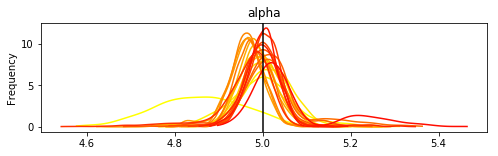

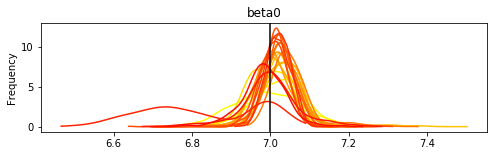

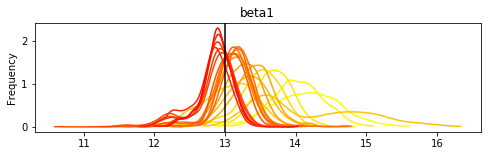

In [11]:
print('Posterior distributions after ' + str(len(traces)) + ' iterations.')
cmap = mpl.cm.autumn
for param in ['alpha', 'beta0', 'beta1']:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({'alpha': alpha_true, 'beta0': beta0_true, 'beta1': beta1_true}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)
    plt.show()

In [12]:
for _ in range(10):

    # generate more data
    X1 = np.random.randn(size)
    X2 = np.random.randn(size) * 0.2
    Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

    model = Model()
    with model:
        # Priors are posteriors from previous iteration
        alpha = from_posterior('alpha', trace['alpha'])
        beta0 = from_posterior('beta0', trace['beta0'])
        beta1 = from_posterior('beta1', trace['beta1'])

        # Expected value of outcome
        mu = alpha + beta0 * X1 + beta1 * X2

        # Likelihood (sampling distribution) of observations
        Y_obs = Normal('Y_obs', mu=mu, sd=1, observed=Y)
                
        # draw 10000 posterior samples
        trace = sample(1000)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 156.72:   6%|▌         | 12078/200000 [00:03<00:49, 3795.07it/s]
Convergence archived at 12200
Interrupted at 12,200 [6%]: Average Loss = 167.39
100%|██████████| 1500/1500 [00:04<00:00, 352.19it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 145.09:   7%|▋         | 13952/200000 [00:03<00:48, 3813.99it/s]
Convergence archived at 14100
Interrupted at 14,100 [7%]: Average Loss = 154.96
100%|██████████| 1500/1500 [00:03<00:00, 407.58it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 141.53:   5%|▌         | 10656/200000 [00:02<00:49, 3854.80it/s]
Convergence archived at 10800
Interrupted at 10,800 [5%]: Average Loss = 151.16
100%|██████████| 1500/1500 [00:03<00:00, 393.20it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 139.76:   7%|▋         | 14756/200000 [00:03<00:46, 4010.98it/s]
Convergence archived at 14800

Posterior distributions after 31 iterations.


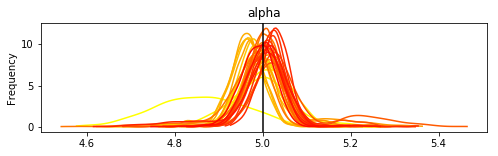

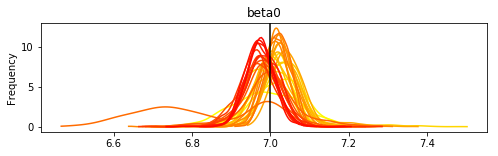

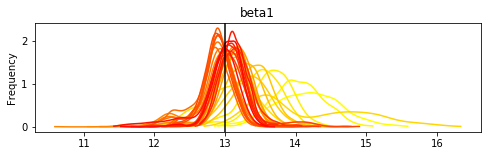

In [13]:
print('Posterior distributions after ' + str(len(traces)) + ' iterations.')
cmap = mpl.cm.autumn
for param in ['alpha', 'beta0', 'beta1']:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({'alpha': alpha_true, 'beta0': beta0_true, 'beta1': beta1_true}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)
    plt.show()